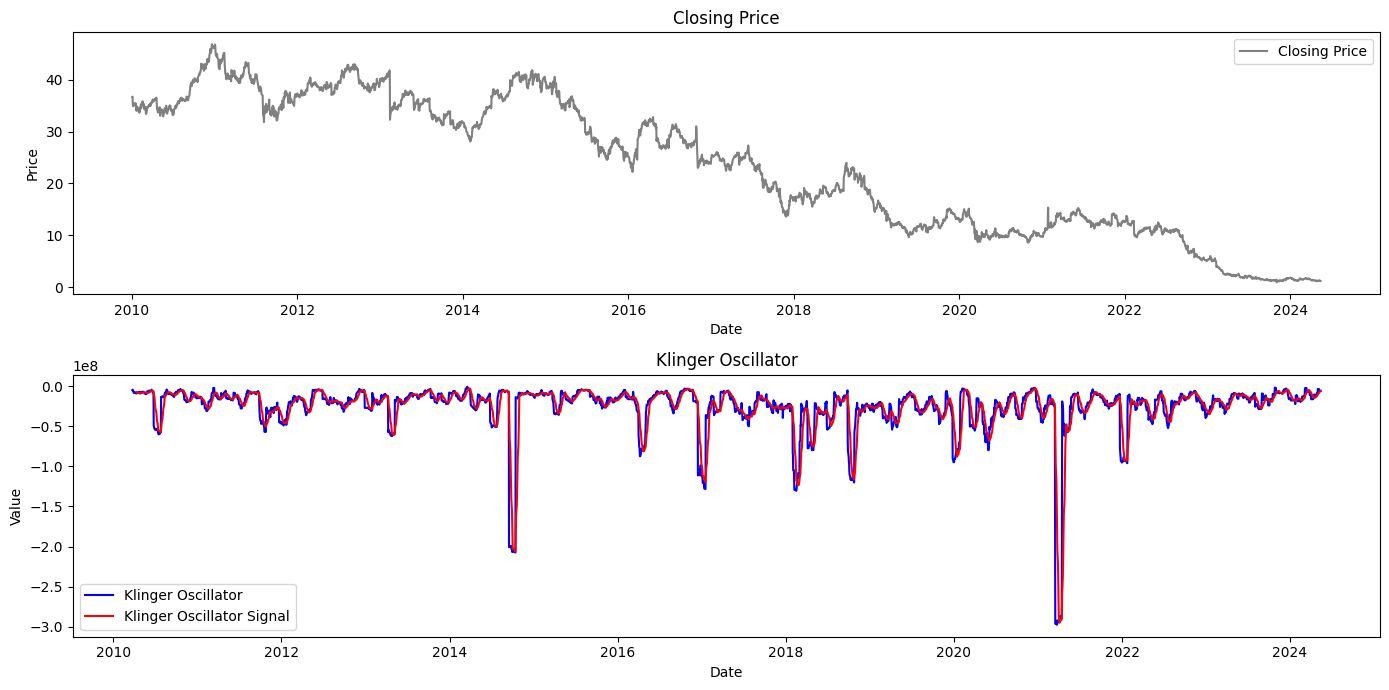

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Disable OpenCL by setting environment variables
os.environ['PYOPENCL_CTX'] = '0'

def load_random_file(data_directory):
    try:
        files = [file for file in os.listdir(data_directory) if file.endswith('.csv')]
        file_path = os.path.join(data_directory, np.random.choice(files))
        return pd.read_csv(file_path), file_path
    except Exception as e:
        print(f"Failed to load file: {e}")
        return None, None

def calculate_klinger_oscillator(df, short_period=34, long_period=55, signal_period=13):
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['Volume']

    typical_price = (high + low + close) / 3
    dm = typical_price.diff()
    dm[dm < 0] = 0

    cmf = volume * dm
    cmf_short = cmf.rolling(window=short_period).sum()
    cmf_long = cmf.rolling(window=long_period).sum()

    kvo = cmf_short - cmf_long
    kvo_signal = kvo.rolling(window=signal_period).mean()

    df['KVO'] = kvo
    df['KVO_Signal'] = kvo_signal

    return df

def plot_klinger_oscillator(df):
    plt.figure(figsize=(14, 7))

    # Plot Closing Price
    plt.subplot(2, 1, 1)
    plt.plot(df['Date'], df['Close'], label='Closing Price', color='gray')
    plt.title('Closing Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    # Plot Klinger Oscillator and Signal
    plt.subplot(2, 1, 2)
    plt.plot(df['Date'], df['KVO'], label='Klinger Oscillator', color='blue')
    plt.plot(df['Date'], df['KVO_Signal'], label='Klinger Oscillator Signal', color='red')
    plt.title('Klinger Oscillator')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
data_directory = 'Data/PriceData'
df, file_path = load_random_file(data_directory)

if df is not None:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date').reset_index(drop=True)

    # Calculate and plot Klinger Oscillator
    df = calculate_klinger_oscillator(df)
    plot_klinger_oscillator(df)
else:
    print("Failed to load data.")


There are NaN values in the seasonal component
Seasonal Components: 0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: Seasonal_Component, dtype: float64


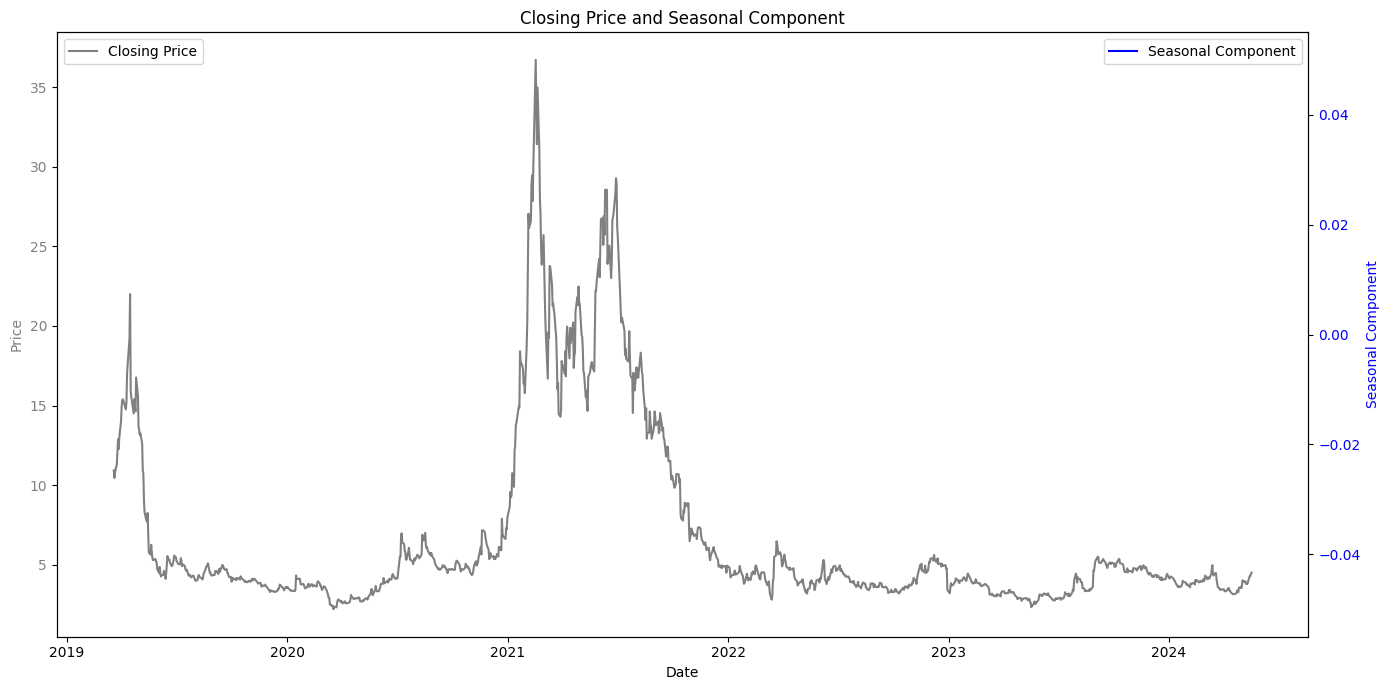

In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Disable OpenCL by setting environment variables
os.environ['PYOPENCL_CTX'] = '0'

def load_random_file(data_directory):
    try:
        files = [file for file in os.listdir(data_directory) if file.endswith('.parquet')]
        file_path = os.path.join(data_directory, np.random.choice(files))
        df = pd.read_parquet(file_path)
        return df, file_path
    except Exception as e:
        print(f"Failed to load file: {e}")
        return None, None

def calculate_rolling_seasonality(df, window_size):
    seasonal_components = []
    min_required_observations = window_size * 2  # Minimum observations required for decomposition

    for i in range(window_size, len(df)):
        window_data = df['Close'].iloc[i-window_size:i]
        
        # Ensure there are enough data points for decomposition
        if len(window_data) < min_required_observations:
            seasonal_components.append(np.nan)
            continue
        
        decomposed = seasonal_decompose(window_data, period=window_size, model='additive')
        seasonal_component = decomposed.seasonal.iloc[-1]  # Get the last value of the seasonal component
        seasonal_components.append(seasonal_component)

    # Pad the beginning with NaNs to match the length of the original DataFrame
    seasonal_components = [np.nan] * window_size + seasonal_components
    df['Seasonal_Component'] = seasonal_components


    ##print if there are any NON nan values
    if df['Seasonal_Component'].isnull().values.any():
        print("There are NaN values in the seasonal component")

    # Print first few seasonal components for debugging
    print("Seasonal Components:", df['Seasonal_Component'].head(10))
    
    return df

def plot_seasonality(df):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot Closing Price
    ax1.plot(df['Date'], df['Close'], label='Closing Price', color='gray')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')
    ax1.legend(loc='upper left')

    # Create a secondary y-axis to plot Seasonal Component
    ax2 = ax1.twinx()
    ax2.plot(df['Date'], df['Seasonal_Component'], label='Seasonal Component', color='blue')
    ax2.set_ylabel('Seasonal Component', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.legend(loc='upper right')

    plt.title('Closing Price and Seasonal Component')
    fig.tight_layout()  # Ensure layout is tight to avoid overlap
    plt.show()

# Example usage
data_directory = 'Data/PriceData'
df, file_path = load_random_file(data_directory)

if df is not None:
    if 'Date' not in df.columns:
        df.reset_index(inplace=True)

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date').reset_index(drop=True)

    # Calculate rolling seasonality
    window_size = 365  # 1 year window for daily data
    df = calculate_rolling_seasonality(df, window_size)

    # Plot seasonality
    plot_seasonality(df)
else:
    print("Failed to load data.")
